# GUVI - Final Project 1 (Sentimental Analysis)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pywsd.lesk import adapted_lesk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk import NaiveBayesClassifier, pos_tag
import warnings
from sklearn.model_selection import train_test_split,ShuffleSplit, cross_val_score,KFold,LeavePOut
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,roc_curve,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from nltk.sentiment.vader import SentimentIntensityAnalyzer

Warming up PyWSD (takes ~10 secs)... took 20.039729833602905 secs.


# Loading The Dataset

In [70]:
df = pd.read_csv('healthcare_reviews.csv')
df.head(10)

,Review_Text,Rating
0,I have mixed feelings about my experience.,4
1,The staff was caring and attentive. I couldn't...,5
2,I have mixed feelings about my experience.,5
3,I have mixed feelings about my experience.,5
4,The healthcare provider was excellent. I had a...,3
5,The staff was caring and attentive. I couldn't...,4
6,NaN,2
7,I had a bad experience with this healthcare pr...,2
8,I have mixed feelings about my experience.,3
9,I have mixed feelings about my experience.,5


# EDA / Feature Engineering

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review_Text  900 non-null    object
 1   Rating       1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [72]:
df.duplicated().sum()

950

<Axes: xlabel='Rating'>

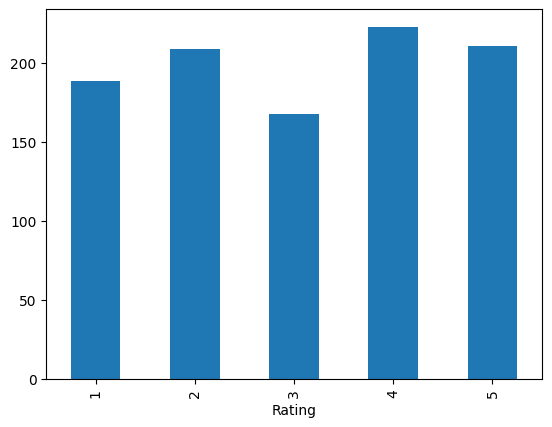

In [73]:
df.groupby('Rating').size().plot(kind='bar')

In [74]:
df.isna().sum()

Review_Text    100
Rating           0
dtype: int64

In [75]:
mode1 = df['Review_Text'].mode()
print(mode1[0])

I'm very satisfied with the service I received. Highly recommended. 


In [76]:
df['Review_Text'] = df.Review_Text.fillna(mode1[0])

In [77]:
##Handling missing values
# from sklearn.preprocessing import LabelEncoder
# from sklearn.impute import KNNImputer

In [78]:
# encoder = LabelEncoder()
# encoded = encoder.fit_transform(df['Review_Text'])
# df['Filled_Review'] = encoded
# df.head()

In [79]:
#imputer = KNNImputer(n_neighbors=2)

# Preprocessing the Data

In [80]:
tfidf = TfidfVectorizer(use_idf=True,strip_accents='ascii')

In [81]:
df.shape

(1000, 2)

In [82]:
import re
def clean_data(review):
    no_pun = re.sub('[^\w\s]','',review)
    digits = ''.join([i for i in no_pun if not i.isdigit()])
    return digits

In [83]:
df['Review_Text'] =df['Review_Text'].apply(clean_data) 
df['Review_Text'][1]

'The staff was caring and attentive I couldnt be happier '

In [84]:
def create_sentiment(rate):
    if rate == 1 or rate ==2:
        sentiment = 'neg'
    elif rate ==3:
        sentiment ='neu'
    elif rate == 4 or rate ==5:
        sentiment = 'pos'
    return sentiment

In [85]:
df['Sentiment'] = df['Rating'].apply(create_sentiment)

In [86]:
df.head(10)

,Review_Text,Rating,Sentiment
0,I have mixed feelings about my experience,4,pos
1,The staff was caring and attentive I couldnt b...,5,pos
2,I have mixed feelings about my experience,5,pos
3,I have mixed feelings about my experience,5,pos
4,The healthcare provider was excellent I had a ...,3,neu
5,The staff was caring and attentive I couldnt b...,4,pos
6,Im very satisfied with the service I received ...,2,neg
7,I had a bad experience with this healthcare pr...,2,neg
8,I have mixed feelings about my experience,3,neu
9,I have mixed feelings about my experience,5,pos


In [87]:
def convert_to_lower(txt):
    return txt.lower()

def tokenize_my_text(txt):
    return word_tokenize(txt)

In [88]:
df['Review_Text'] =df['Review_Text'].apply(convert_to_lower) 
df['Token_Text'] = df['Review_Text'].apply(tokenize_my_text)

In [89]:
from nltk.corpus import stopwords

In [90]:
stop_words = set(stopwords.words('english'))

In [91]:
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stop_words]
        

In [92]:
df['Cleaned_Review'] = df['Token_Text'].apply(remove_stop_words)

In [93]:
df.head()

,Review_Text,Rating,Sentiment,Token_Text,Cleaned_Review
0,i have mixed feelings about my experience,4,pos,"[i, have, mixed, feelings, about, my, experience]","[mixed, feelings, experience]"
1,the staff was caring and attentive i couldnt b...,5,pos,"[the, staff, was, caring, and, attentive, i, c...","[staff, caring, attentive, couldnt, happier]"
2,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]","[mixed, feelings, experience]"
3,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]","[mixed, feelings, experience]"
4,the healthcare provider was excellent i had a ...,3,neu,"[the, healthcare, provider, was, excellent, i,...","[healthcare, provider, excellent, great, exper..."


In [94]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [95]:
stemmer = PorterStemmer()

In [96]:
def txt_stemming(tokens):
    return [stemmer.stem(i) for i in tokens]

In [97]:
df['Cleaned_Review'] = df['Cleaned_Review'].apply(txt_stemming)

In [98]:
df.head()

,Review_Text,Rating,Sentiment,Token_Text,Cleaned_Review
0,i have mixed feelings about my experience,4,pos,"[i, have, mixed, feelings, about, my, experience]","[mix, feel, experi]"
1,the staff was caring and attentive i couldnt b...,5,pos,"[the, staff, was, caring, and, attentive, i, c...","[staff, care, attent, couldnt, happier]"
2,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]","[mix, feel, experi]"
3,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]","[mix, feel, experi]"
4,the healthcare provider was excellent i had a ...,3,neu,"[the, healthcare, provider, was, excellent, i,...","[healthcar, provid, excel, great, experi]"


In [99]:
lemma = WordNetLemmatizer()
def my_lemmatizer(token):
    return [lemma.lemmatize(word=w,pos='v') for w in token]

In [100]:
df['Cleaned_Review'] = df['Token_Text'].apply(remove_stop_words)
df['Cleaned_Review'] = df['Cleaned_Review'].apply(my_lemmatizer)
df.head()

,Review_Text,Rating,Sentiment,Token_Text,Cleaned_Review
0,i have mixed feelings about my experience,4,pos,"[i, have, mixed, feelings, about, my, experience]","[mix, feel, experience]"
1,the staff was caring and attentive i couldnt b...,5,pos,"[the, staff, was, caring, and, attentive, i, c...","[staff, care, attentive, couldnt, happier]"
2,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]","[mix, feel, experience]"
3,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]","[mix, feel, experience]"
4,the healthcare provider was excellent i had a ...,3,neu,"[the, healthcare, provider, was, excellent, i,...","[healthcare, provider, excellent, great, exper..."


In [101]:
def list_to_string(token):
    return ' '.join(token)

In [102]:
df1['Cleaned_Review'] = df1['Cleaned_Review'].apply(list_to_string)
df1['Cleaned_Review']

0       
1       
2       
3       
4       
      ..
995     
996     
997     
998     
999     
Name: Cleaned_Review, Length: 1000, dtype: object

In [103]:
# def min_len_filter(token):
#     fl = []
#     for w in token:
#         if len(w) >2:
#             fl.append(w)
#     return fl


In [104]:
df['Cleaned_Review'] = df['Cleaned_Review'].apply(min_len_filter)
df['Cleaned_Review']

0                                [mix, feel, experience]
1             [staff, care, attentive, couldnt, happier]
2                                [mix, feel, experience]
3                                [mix, feel, experience]
4      [healthcare, provider, excellent, great, exper...
                             ...                        
995    [experience, terrible, would, recommend, provi...
996              [service, disappoint, wont, come, back]
997                [service, okay, nothing, exceptional]
998                              [mix, feel, experience]
999           [staff, care, attentive, couldnt, happier]
Name: Cleaned_Review, Length: 1000, dtype: object

In [106]:
wcwords = ''
df_exp = df[['Cleaned_Review']]

for i,row in df_exp.iterrows():
    for word in row[0]:
        wcwords += ' '+word


# Data visualization

In [107]:
from wordcloud import WordCloud, STOPWORDS

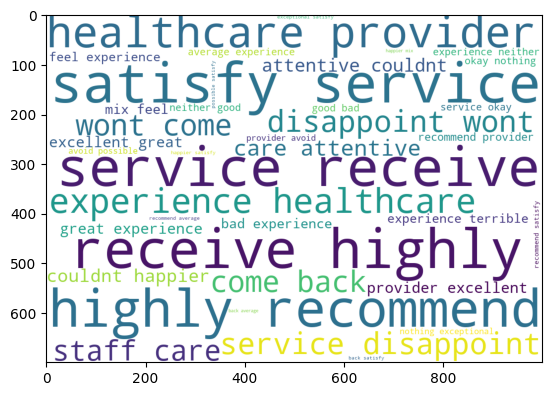

In [108]:
wordcloud = WordCloud(width = 1000, height = 700, background_color="white").generate(wcwords)
plt.figure()
plt.imshow(wordcloud)

In [109]:
# word_features = [wcwords]
# def document_features(document):
#     print(document)
#     document_words = set(document)
#     features = {}
#     for word in word_features:
#         #print(word)
#         features['contains({})'.format(word)] = (word in document_words)
#     return features


In [110]:
df1=df

In [111]:
from collections import Counter

In [115]:
c = Counter(all_wrd)


NameError: name 'all_wrd' is not defined

In [114]:
import nltk
freq_dist_pos = nltk.FreqDist(all_wrd)
print(freq_dist_pos.most_common(20))

NameError: name 'all_wrd' is not defined

In [116]:
def list_to_string(token):
    return ' '.join(token)

In [117]:
df1['Cleaned_Review'] = df1['Cleaned_Review'].apply(list_to_string)
df1['Cleaned_Review']

0                                 mix feel experience
1                staff care attentive couldnt happier
2                                 mix feel experience
3                                 mix feel experience
4      healthcare provider excellent great experience
                            ...                      
995      experience terrible would recommend provider
996                 service disappoint wont come back
997                  service okay nothing exceptional
998                               mix feel experience
999              staff care attentive couldnt happier
Name: Cleaned_Review, Length: 1000, dtype: object

In [118]:
df1

,Review_Text,Rating,Sentiment,Token_Text,Cleaned_Review
0,i have mixed feelings about my experience,4,pos,"[i, have, mixed, feelings, about, my, experience]",mix feel experience
1,the staff was caring and attentive i couldnt b...,5,pos,"[the, staff, was, caring, and, attentive, i, c...",staff care attentive couldnt happier
2,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]",mix feel experience
3,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]",mix feel experience
4,the healthcare provider was excellent i had a ...,3,neu,"[the, healthcare, provider, was, excellent, i,...",healthcare provider excellent great experience
...,...,...,...,...,...
995,my experience was terrible i would not recomme...,5,pos,"[my, experience, was, terrible, i, would, not,...",experience terrible would recommend provider
996,the service was disappointing i wont be coming...,4,pos,"[the, service, was, disappointing, i, wont, be...",service disappoint wont come back
997,the service was okay but nothing exceptional,3,neu,"[the, service, was, okay, but, nothing, except...",service okay nothing exceptional
998,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]",mix feel experience


In [119]:
neu = df1.query('Cleaned_Review == "mix feel experience" and Rating <3')
neu.shape

(34, 5)

In [120]:
rat3 = df1.query('Rating == 1')
rat3

,Review_Text,Rating,Sentiment,Token_Text,Cleaned_Review
10,the service was okay but nothing exceptional,1,neg,"[the, service, was, okay, but, nothing, except...",service okay nothing exceptional
19,the service was disappointing i wont be coming...,1,neg,"[the, service, was, disappointing, i, wont, be...",service disappoint wont come back
21,im very satisfied with the service i received ...,1,neg,"[im, very, satisfied, with, the, service, i, r...",satisfy service receive highly recommend
33,i had a bad experience with this healthcare pr...,1,neg,"[i, had, a, bad, experience, with, this, healt...",bad experience healthcare provider avoid possible
35,i had a bad experience with this healthcare pr...,1,neg,"[i, had, a, bad, experience, with, this, healt...",bad experience healthcare provider avoid possible
...,...,...,...,...,...
963,im very satisfied with the service i received ...,1,neg,"[im, very, satisfied, with, the, service, i, r...",satisfy service receive highly recommend
975,the staff was caring and attentive i couldnt b...,1,neg,"[the, staff, was, caring, and, attentive, i, c...",staff care attentive couldnt happier
979,the service was okay but nothing exceptional,1,neg,"[the, service, was, okay, but, nothing, except...",service okay nothing exceptional
992,the service was disappointing i wont be coming...,1,neg,"[the, service, was, disappointing, i, wont, be...",service disappoint wont come back


In [121]:
analyzer = SentimentIntensityAnalyzer()
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    #print(scores)
    if scores['neu'] == 1.0:
        return 0
    elif scores['pos'] == 1.0:
        return 1
    elif scores['neg'] == 1.0:
        retunr -1
    if scores['compound'] > 0.5:
        return 1
    elif scores['compound'] > 0 and scores['compound'] < 0.5:
        return 0
    elif scores['compound'] < 0:
        return -1
        


In [122]:
get_sentiment('mix feel experience')

0

In [123]:
df1['New_Rating'] = df['Cleaned_Review'].apply(get_sentiment)

In [124]:
df1

,Review_Text,Rating,Sentiment,Token_Text,Cleaned_Review,New_Rating
0,i have mixed feelings about my experience,4,pos,"[i, have, mixed, feelings, about, my, experience]",mix feel experience,0
1,the staff was caring and attentive i couldnt b...,5,pos,"[the, staff, was, caring, and, attentive, i, c...",staff care attentive couldnt happier,0
2,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]",mix feel experience,0
3,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]",mix feel experience,0
4,the healthcare provider was excellent i had a ...,3,neu,"[the, healthcare, provider, was, excellent, i,...",healthcare provider excellent great experience,1
...,...,...,...,...,...,...
995,my experience was terrible i would not recomme...,5,pos,"[my, experience, was, terrible, i, would, not,...",experience terrible would recommend provider,-1
996,the service was disappointing i wont be coming...,4,pos,"[the, service, was, disappointing, i, wont, be...",service disappoint wont come back,-1
997,the service was okay but nothing exceptional,3,neu,"[the, service, was, okay, but, nothing, except...",service okay nothing exceptional,0
998,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]",mix feel experience,0


(1000, 6)

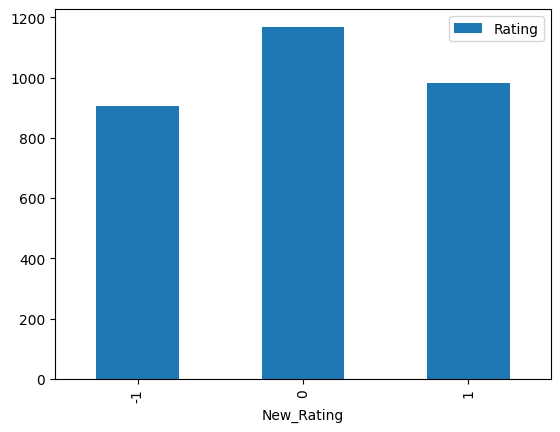

In [125]:
df1.groupby(['New_Rating']).sum().plot(kind='bar')
df1.shape

In [126]:
tfidf = TfidfVectorizer(strip_accents='ascii',lowercase=True,preprocessor=None, use_idf=True, norm='l2')

In [127]:
df1.head(10)

,Review_Text,Rating,Sentiment,Token_Text,Cleaned_Review,New_Rating
0,i have mixed feelings about my experience,4,pos,"[i, have, mixed, feelings, about, my, experience]",mix feel experience,0
1,the staff was caring and attentive i couldnt b...,5,pos,"[the, staff, was, caring, and, attentive, i, c...",staff care attentive couldnt happier,0
2,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]",mix feel experience,0
3,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]",mix feel experience,0
4,the healthcare provider was excellent i had a ...,3,neu,"[the, healthcare, provider, was, excellent, i,...",healthcare provider excellent great experience,1
5,the staff was caring and attentive i couldnt b...,4,pos,"[the, staff, was, caring, and, attentive, i, c...",staff care attentive couldnt happier,0
6,im very satisfied with the service i received ...,2,neg,"[im, very, satisfied, with, the, service, i, r...",satisfy service receive highly recommend,1
7,i had a bad experience with this healthcare pr...,2,neg,"[i, had, a, bad, experience, with, this, healt...",bad experience healthcare provider avoid possible,-1
8,i have mixed feelings about my experience,3,neu,"[i, have, mixed, feelings, about, my, experience]",mix feel experience,0
9,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]",mix feel experience,0


In [128]:
encoder = LabelEncoder()
encode = encoder.fit_transform(df1['Sentiment'])
df1['EncodedSentiment'] = encode

In [129]:
print(encode)
df.head(10)

[2 2 2 2 1 2 0 0 1 2 0 1 1 2 0 1 1 2 2 0 2 0 2 0 2 2 2 2 2 2 2 2 0 0 1 0 2
 0 2 0 2 0 0 2 0 1 1 0 2 2 1 2 0 2 0 1 0 2 0 2 0 2 2 2 0 2 2 0 2 0 0 1 0 0
 2 0 1 2 2 0 2 2 2 1 0 1 0 2 0 2 0 0 2 2 1 2 0 0 2 2 0 1 2 2 2 2 0 0 2 2 2
 1 2 2 0 0 0 2 2 0 2 0 1 2 2 1 2 0 0 1 2 0 2 2 0 1 1 0 0 0 2 0 1 0 2 2 2 2
 0 0 2 0 2 0 2 2 0 0 0 1 0 0 0 0 0 0 2 1 0 2 0 0 1 2 2 0 0 2 0 0 0 0 0 0 2
 0 2 2 0 1 2 0 2 2 1 0 0 2 0 1 2 1 0 0 2 0 2 0 2 1 2 2 0 0 0 0 1 2 0 1 1 0
 0 0 1 2 0 0 2 2 2 0 0 2 2 0 2 2 2 1 0 2 1 1 2 2 1 2 2 0 2 1 1 2 2 2 1 0 2
 2 2 2 1 2 2 1 0 2 0 0 0 2 2 0 0 1 2 0 2 0 0 2 0 2 2 2 0 2 2 0 1 2 2 2 0 0
 0 0 0 0 2 0 0 0 1 2 2 0 1 2 2 0 0 0 1 2 0 0 0 2 0 1 2 0 0 2 0 2 1 2 1 0 0
 2 2 0 0 0 1 2 0 1 0 2 0 0 1 2 1 2 0 0 2 2 2 0 2 1 0 0 1 0 2 2 0 2 0 2 2 2
 1 2 0 1 2 2 0 1 0 2 0 0 1 0 2 2 0 2 2 2 2 0 0 0 2 0 2 2 1 2 2 1 2 2 2 0 0
 2 2 0 0 2 2 2 0 2 2 0 0 2 0 0 2 0 1 0 0 0 1 1 2 0 2 0 1 1 2 2 2 0 2 0 0 0
 2 1 0 1 2 0 2 1 0 1 0 1 0 2 0 0 0 0 0 2 0 2 0 2 2 1 1 0 0 2 2 0 2 0 2 0 2
 2 2 2 2 2 2 0 2 2 2 1 0 

,Review_Text,Rating,Sentiment,Token_Text,Cleaned_Review,New_Rating,EncodedSentiment
0,i have mixed feelings about my experience,4,pos,"[i, have, mixed, feelings, about, my, experience]",mix feel experience,0,2
1,the staff was caring and attentive i couldnt b...,5,pos,"[the, staff, was, caring, and, attentive, i, c...",staff care attentive couldnt happier,0,2
2,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]",mix feel experience,0,2
3,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]",mix feel experience,0,2
4,the healthcare provider was excellent i had a ...,3,neu,"[the, healthcare, provider, was, excellent, i,...",healthcare provider excellent great experience,1,1
5,the staff was caring and attentive i couldnt b...,4,pos,"[the, staff, was, caring, and, attentive, i, c...",staff care attentive couldnt happier,0,2
6,im very satisfied with the service i received ...,2,neg,"[im, very, satisfied, with, the, service, i, r...",satisfy service receive highly recommend,1,0
7,i had a bad experience with this healthcare pr...,2,neg,"[i, had, a, bad, experience, with, this, healt...",bad experience healthcare provider avoid possible,-1,0
8,i have mixed feelings about my experience,3,neu,"[i, have, mixed, feelings, about, my, experience]",mix feel experience,0,1
9,i have mixed feelings about my experience,5,pos,"[i, have, mixed, feelings, about, my, experience]",mix feel experience,0,2


In [130]:
# df1 = df1.drop(['Review_Text','Sentiment','Token_Text','Rating'], axis=1)
# df1
#df1 = df1.drop(['New_Rating'],axis=1)

## Model Building

In [138]:
from sklearn.metrics import r2_score
X_train, X_test, y_train, y_test = train_test_split(tfidf.fit_transform(df1.Cleaned_Review), df1.EncodedSentiment, test_size=0.033, random_state=17) 
# Create the decision tree classifier 

rf = RandomForestClassifier(n_estimators = 10, criterion='entropy',max_depth=10,min_samples_split=8, min_samples_leaf=2, 
min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=4,oob_score=False, n_jobs=1, random_state=42, verbose=0, warm_start=False,class_weight=None)
# Fit the classifier to the training data 
rf.fit(X_train, y_train) 
# Predict the classes of the testing data 
y_pred = rf.predict(X_test)
# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred) 
print("RFC Accuracy:", accuracy)

print("Accuracy is not upto the mark")
clf = DecisionTreeClassifier() 
clf.fit(X_train, y_train) 
# Predict the classes of the testing data 
y_pred = clf.predict(X_test)
# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred) 
print("DTC Accuracy:", accuracy)

print("##Gradient Boosting ")
xb = GradientBoostingClassifier(n_estimators = 15, random_state=46)
xb.fit(X_train, y_train)
xbpred = xb.predict(X_test)
accuracy = accuracy_score(y_test,xbpred)
print("GBoost Accuracy:", accuracy)
print('R2 score: ',r2_score(y_test, xbpred))

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# print("##KNN")
# knn = KNeighborsClassifier()
# knn.fit(X_train,y_train)
# kpred = knn.predict(X_test)
# accuracy = accuracy_score(y_test,kpred)
# print("KNN Accuracy:", accuracy)
sv = SVC(random_state=42)
sv.fit(X_train,y_train)
svpred = sv.predict(X_test)
print("SVM accuracy", accuracy_score(y_test,svpred))


##Hyper parameter tuneing
grid_param = {'n_neighbors':[10,20,30,40,50]}
grid = {'random_state':[1,5,10,15]}
grid_rf = GridSearchCV(estimator=sv,param_grid=grid,scoring='accuracy')

grid_rf.fit(X_train,y_train)
print(grid_rf.best_score_)
print(grid_rf.best_params_)

rs_rf = RandomizedSearchCV(estimator = sv, param_distributions=grid,scoring='accuracy',n_iter=15)
rs_rf.fit(X_train,y_train)
rspred = rs_rf.predict(X_test)
print("Randomized Search", accuracy_score(y_test,rspred))


RFC Accuracy: 0.5757575757575758
Accuracy is not upto the mark
DTC Accuracy: 0.6060606060606061
##Gradient Boosting 
GBoost Accuracy: 0.6363636363636364
R2 score:  -0.27467811158798283
SVM accuracy 0.6363636363636364
R2 score:  -0.27467811158798283
0.39708883072485446
{'random_state': 1}


C:\Python311\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 4 is smaller than n_iter=15. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Randomized Search 0.6363636363636364
R2 score:  -0.27467811158798283


In [135]:
from sklearn.metrics import r2_score
linear_regression=LogisticRegression()
linear_regression.fit(X_train, y_train)
pred = linear_regression.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print(accuracy)

0.6363636363636364
R2 score:  -0.27467811158798283


# Model Evaluations

In [1]:
shuffle_split=ShuffleSplit(test_size=0.033,train_size=0.967,n_splits=7)
K_fold_validation=KFold(n_splits=17)
cross_val_scores=cross_val_score(xb,tfidf.fit_transform(df1.Cleaned_Review),df1.EncodedSentiment,cv=shuffle_split)

print("cross Validation cross_val_scores:n {}".format(cross_val_scores))
print("Average Cross Validation score :{}".format(cross_val_scores.mean()))


NameError: name 'ShuffleSplit' is not defined

In [353]:
print(classification_report(y_test, pred))
#tfidf.fit_transform(df1.Cleaned_Review)

              precision    recall  f1-score   support

           0       0.83      0.42      0.56        12
           1       0.00      0.00      0.00         4
           2       0.59      0.94      0.73        17

    accuracy                           0.64        33
   macro avg       0.48      0.45      0.43        33
weighted avg       0.61      0.64      0.58        33



C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [354]:
cf_matrix = confusion_matrix(y_test, pred)
cf_matrix

array([[ 5,  0,  7],
       [ 0,  0,  4],
       [ 1,  0, 16]], dtype=int64)

In [393]:
import nltk
new_Data = "very bad"
xx = remove_stop_words(nltk.word_tokenize(new_Data))
xx

['bad']

In [394]:
linear_regression.fit(X_train, y_train)

LogisticRegression()

In [395]:
array = tfidf.transform(xx)
new_pred = linear_regression.predict(array)

In [396]:
#0 - Neg, 1 - Neutral 2 - Positive
new_pred

array([0])

In [397]:
##Recommendations

In [398]:
neg_df = df1.query('EncodedSentiment == 0')
neg_df

,Cleaned_Review,EncodedSentiment
6,satisfy service receive highly recommend,0
7,bad experience healthcare provider avoid possible,0
10,service okay nothing exceptional,0
14,bad experience healthcare provider avoid possible,0
19,service disappoint wont come back,0
...,...,...
981,satisfy service receive highly recommend,0
985,staff care attentive couldnt happier,0
990,satisfy service receive highly recommend,0
992,service disappoint wont come back,0


In [426]:
all_wrd = []
for w in neg_df['Cleaned_Review']:
    for word in nltk.word_tokenize(w):
        all_wrd.append(word)   

In [463]:
freq_words = nltk.FreqDist(all_wrd)
flist = freq_words.most_common(10)
word_map = {}
for tup in flist:
    word_map[tup[0]] = tup[1]
word_map  
word_df = pd.DataFrame({'word':word_map.keys(),'count':word_map.values()})


# Some more insights of the data

<Axes: xlabel='count', ylabel='word'>

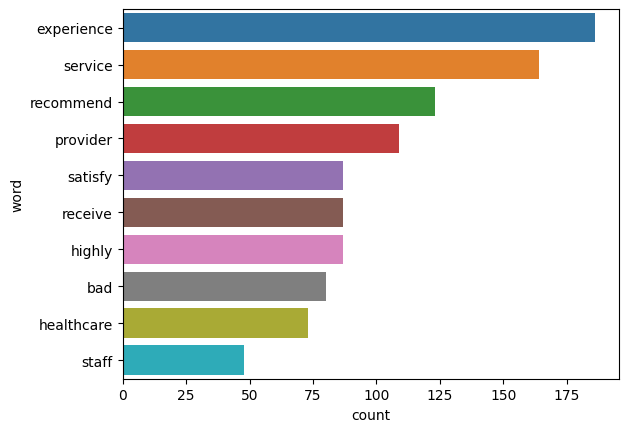

In [504]:
sns.barplot(data=word_df,y='word',x='count', label='Most frequently used words')

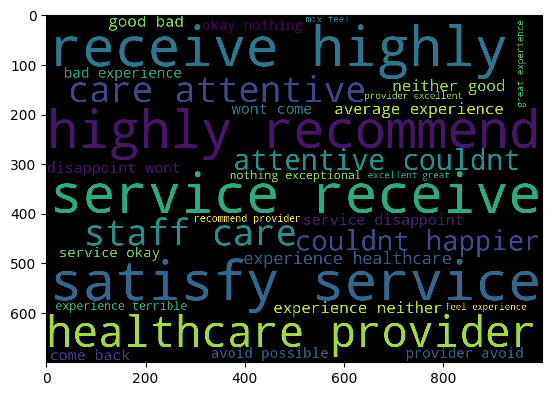

In [487]:
reqwords = list_to_string(all_wrd)
wordcloud = WordCloud(width = 1000, height = 700, background_color="black",).generate(reqwords)
plt.figure()
plt.imshow(wordcloud,interpolation='none')


In [502]:
# from sklearn.linear_model import Lasso
# #import r2_score
# from sklearn.metrics import r2_score
# lasso = Lasso()
# lasso.fit(X_train, y_train)
# x_pred_lasso_test = lasso.predict(X_test)
# r2_score(y_test, x_pred_lasso_test)

In [428]:
#df['Sentiment'] = df['Rating'].apply(create_sentiment)

In [538]:
df1 = df
#

In [402]:
df1

,Rating,Cleaned_Review,New_Sentiment,New_Rate
0,4,mix feel experience,1,0
1,5,staff care attentive couldnt happier,1,0
2,5,mix feel experience,1,0
3,5,mix feel experience,1,0
4,3,healthcare provider excellent great experience,0,1
...,...,...,...,...
995,5,experience terrible would recommend provider,1,0
996,4,service disappoint wont come back,1,0
997,3,service okay nothing exceptional,0,0
998,5,mix feel experience,1,0


In [494]:
df

,Review_Text,Rating
0,I have mixed feelings about my experience.,4
1,The staff was caring and attentive. I couldn't...,5
2,I have mixed feelings about my experience.,5
3,I have mixed feelings about my experience.,5
4,The healthcare provider was excellent. I had a...,3
...,...,...
995,My experience was terrible. I would not recomm...,5
996,The service was disappointing. I won't be comi...,4
997,"The service was okay, but nothing exceptional.",3
998,I have mixed feelings about my experience.,5


<Axes: xlabel='New_Sentiment'>

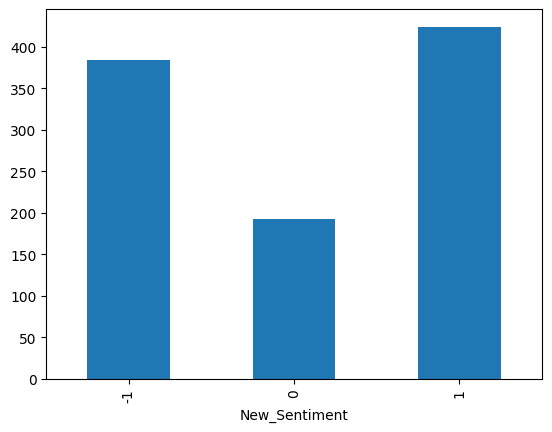

In [353]:
df.groupby('New_Sentiment').size().plot(kind='bar')

In [404]:
df.groupby('New_Sentiment').size()

New_Sentiment
-1    384
 0    192
 1    424
dtype: int64

In [405]:
df.groupby('Sentiment').size()

Sentiment
neg    398
neu    168
pos    434
dtype: int64

In [406]:
def skip_unwanted(pos_tuple):
    word, tag = pos_tuple
    if tag.startswith("NN"):
        return False
    return True

In [407]:
unwanted = stopwords.words("english")

positive_words = [word for word, tag in filter(
    skip_unwanted,
    pos_tag(df[df['Sentiment']==1]['Cleaned_Review'])
)]
negative_words = [word for word, tag in filter(
    skip_unwanted,
    pos_tag(df[df['Sentiment']==-1]['Cleaned_Review'])
)]

neutral_words = [word for word, tag in filter(
    skip_unwanted,
    pos_tag(df[df['Sentiment']==0]['Cleaned_Review'])
)]

In [408]:
positive_fd = FreqDist(positive_words)
#negative_fd = FreqDist(negative_words)
#neutral_fd = FreqDist(neutral_words)

In [409]:
df1

,Rating,Cleaned_Review,New_Sentiment,New_Rate
0,4,mix feel experience,1,0
1,5,staff care attentive couldnt happier,1,0
2,5,mix feel experience,1,0
3,5,mix feel experience,1,0
4,3,healthcare provider excellent great experience,0,1
...,...,...,...,...
995,5,experience terrible would recommend provider,1,0
996,4,service disappoint wont come back,1,0
997,3,service okay nothing exceptional,0,0
998,5,mix feel experience,1,0


In [410]:
df1['New_Rate'] = df1['Cleaned_Review'].apply(new_rating)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
neutral
{'neg': 0.309, 'neu': 0.334, 'pos': 0.357, 'compound': 0.1088}
neutral
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
neutral
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
neutral
{'neg': 0.0, 'neu': 0.278, 'pos': 0.722, 'compound': 0.8316}
positive
{'neg': 0.309, 'neu': 0.334, 'pos': 0.357, 'compound': 0.1088}
neutral
{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.6997}
positive
{'neg': 0.588, 'neu': 0.412, 'pos': 0.0, 'compound': -0.6908}
negative
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
neutral
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
neutral
{'neg': 0.0, 'neu': 0.612, 'pos': 0.388, 'compound': 0.2263}
neutral
{'neg': 0.0, 'neu': 0.612, 'pos': 0.388, 'compound': 0.2263}
neutral
{'neg': 0.0, 'neu': 0.278, 'pos': 0.722, 'compound': 0.8316}
positive
{'neg': 0.0, 'neu': 0.612, 'pos': 0.388, 'compound': 0.2263}
neutral
{'neg': 0.588, 'neu': 0.412, 'pos': 0.0, 'compound': -0.6908

In [411]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [412]:
sample = 'staff care attentive couldnt happier'
def new_rating(sample):
    ana = analyzer.polarity_scores(sample)
    print(ana)
    if ana['compound'] <= -0.5:
        print('negative')
        return -1
    elif ana['compound'] > 0.5:
        print('positive')
        return 1
    else:
        print('neutral')
        return 0

In [413]:
sent = new_rating('staff care attentive couldnt happier')
print(sent)

{'neg': 0.309, 'neu': 0.334, 'pos': 0.357, 'compound': 0.1088}
neutral
0
